# Compare models


In [105]:
import numpy as np
from matsindy.feature_library import FeatureLibrary

from ipywidgets import interactive, fixed
import ipywidgets as widgets
%matplotlib inline
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
plt.rcParams['figure.figsize'] = [15, 12]

## Datasets selection

In [2]:
n_links = 1024
L_max = np.sqrt(3*n_links)

dataset_files = {
    'Kramers': f'outputs/Kramers/Wi100_N1024_contraction_0_n256.npz',
}
# Load data with rescaling
dataset = {}
for name, file in dataset_files.items():
    with np.load(file) as data:
        temp = dict(data)
        # Rename variables
        tau = 0.0142*n_links**2
        temp['S'] = temp.pop('S_average')
        temp['A'] = temp.pop('A_average')/n_links*3
        temp['∇U'] = temp.pop('gradU')*tau
        temp['t'] = temp['t']/tau
        # Add transposed variables
        
        temp['∇Uᵀ'] = np.transpose(temp['∇U'], axes=(0, 2, 1))
        # Save
        dataset[name] = temp

In [3]:
from matsindy.special import simulate_from_literature
from tqdm import tqdm

simulated_dataset = {}
for scenario, data in tqdm(dataset.items()):
    simulated_dataset[scenario] = {
        'FENE-P' : simulate_from_literature('FENE-P', data['A'][0], data['t'], data['∇U'], L_max=L_max, subdivide=100),
#        'FENE-CR' : simulate_from_literature('FENE-CR', data['A'][0], data['t'], data['∇U'], L_max=L_max, subdivide=2),
        'Hinch-Larson' : simulate_from_literature('Hinch-Larson', data['A'][0], data['t'], data['∇U'], L_max=L_max, subdivide=100),
        'FENE-kink' : simulate_from_literature('FENE-kink', data['A'][0], data['t'], data['∇U'], L_max=L_max, subdivide=100)
    }

100%|██████████| 1/1 [00:32<00:00, 32.63s/it]


In [4]:
def inspect(models, scenario, line, plot_L_max):

    ln = ['x', 'y', 'z']
    t = dataset[scenario]['t']
    A = dataset[scenario]['A']
    A_sim = simulated_dataset[scenario]
    
    fig, ax = plt.subplots(nrows=2)
    
    ax[0].plot(t, A[:,line,0], c='#0c2c84', linewidth=2, label=f'{ln[line]}x')
    

    ax[0].plot(t, A[:,line,1], c='#1d91c0', linewidth=2, label=f'{ln[line]}y')

    ax[0].plot(t, A[:,line,2], c='#7fcdbb', linewidth=2, label=f'{ln[line]}z')
    
    ax[1].plot(t, A[:,0,0]+A[:,1,1]+A[:,2,2], c='#1d91c0', linewidth=2, label='trace')
    
    m = ['--', ':', '-.']
    
    for i, model in enumerate(models):
        ax[0].plot(t, A_sim[model][:,line,0], m[i], c='#0c2c84', linewidth=2, label=f'{ln[line]}x {model}')
        ax[0].plot(t, A_sim[model][:,line,2], m[i], c='#7fcdbb', linewidth=2, label=f'{ln[line]}z {model}')
        ax[0].plot(t, A_sim[model][:,line,1], m[i], c='#1d91c0', linewidth=2, label=f'{ln[line]}y {model}')
        ax[1].semilogy(t, A_sim[model][:,0,0]+A_sim[model][:,1,1]+A_sim[model][:,2,2], m[i], c='k', linewidth=2, label=f'trace {model}')
    
    
    
    if plot_L_max:
        ax[1].axhline(L_max**2, color='#7fcdbb', label='L_max²' )
        ax[1].axhline(np.sqrt(3)*L_max, ls=':', color='#7fcdbb', label='L_max' )
        ax[1].axhline(3, ls='--', color='#7fcdbb', label='1' )
    
    ax[0].legend()
    ax[1].legend()
    plt.show()


w = interactive(inspect, 
                models=widgets.SelectMultiple(
                    options=list(simulated_dataset[scenario].keys()),
                    value=list(simulated_dataset[scenario].keys()),
                    rows=len(simulated_dataset[scenario]),
                    description='Models',
                    disabled=False
                    ),
                    scenario=widgets.Dropdown(
                    options=list(dataset.keys()),
                    value=next(iter(dataset.keys())),
                    description='Scenario:',
                    disabled=False,
                    ),
                    line=widgets.Dropdown(
                    options=[('xx, xy, xz', 0),('yx, yy, yz', 1),('zx, zy, zz', 2)],
                    value=0,
                    description='Line:',
                    disabled=False,
                    ),
                    plot_L_max=widgets.Checkbox(
                    value=False,
                    description='Display L_max²',
                    )
               )
w

interactive(children=(SelectMultiple(description='Models', index=(0, 1, 2), options=('FENE-P', 'Hinch-Larson',…

## Mechanochemistry

In [5]:
Wi_c =  10
threshold = Wi_c/(8*0.0142)

for scenario, data in dataset.items():
    population = np.zeros_like(data['t'])
    for molecule in data['g_max']:
        for i, g in enumerate(molecule):
            if g < threshold:
                population[i] += 1
            else:
                break
    data['population'] = population/len(data['g_max'])

In [6]:
# Simulated with intrinsic (from Borwnian dynamics) conformation tensor
for scenario, data in dataset.items():
    trA = np.trace(data['A'], axis1=1, axis2=2)
    A_dot_gradU = np.trace(data['A'] @ data['∇U'], axis1=1, axis2=2)
    #k = 1.4*np.trace(data['A'] @ data['∇U'], axis1=1, axis2=2)**2/Wi_c/np.trace(data['A'], axis1=1, axis2=2)/L_max**2
    a = 0.
    k = 15.*A_dot_gradU**2/Wi_c/(trA**(2*a)*(L_max**2)**(2-2*a))
    
    k[A_dot_gradU/trA<Wi_c] = 0
    
    pop_sim = np.ones_like(data['t'])
    dts = np.diff(data['t'])
    for i, dt in enumerate(dts):
        pop_sim[i+1] = pop_sim[i] - dt*pop_sim[i]*k[i]
    
    data['k_sim'] = k
    data['pop_sim'] = pop_sim
    

In [7]:
def inspect_mechanochem(scenario):

    t = dataset[scenario]['t']
    pop = dataset[scenario]['population']
    
    fig, ax = plt.subplots(nrows=2)
    
    ax[0].plot(t, pop, c='#0c2c84', linewidth=2)
    ax[0].plot(t, dataset[scenario]['pop_sim'], c='#7fcdbb', linewidth=2)
    
    ax[1].plot(t[1:], -np.diff(pop)/pop[1:]/np.diff(t), c='#0c2c84', linewidth=2)
    ax[1].plot(t, dataset[scenario]['k_sim'], c='#7fcdbb', linewidth=2)
    plt.show()


w2 = interactive(inspect_mechanochem, 
                scenario=widgets.Dropdown(
                    options=list(dataset.keys()),
                    value=next(iter(dataset.keys())),
                    description='Scenario:',
                    disabled=False,
                    ),
               )
w2

interactive(children=(Dropdown(description='Scenario:', options=('Kramers',), value='Kramers'), Output()), _do…

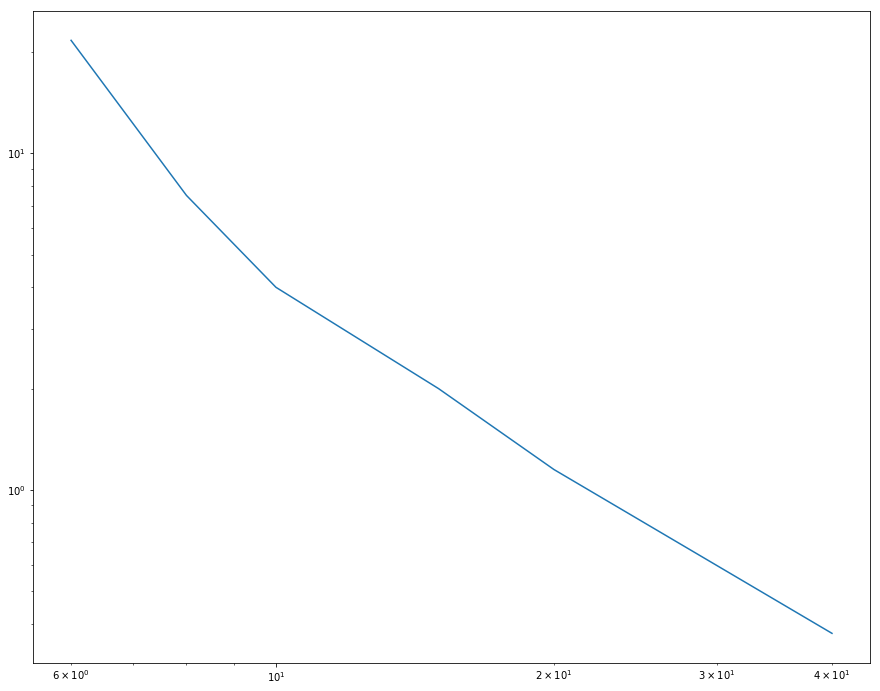

In [8]:
x = np.array([6, 8, 10, 15, 20, 40])
y = np.array([130, 60, 40, 30, 23, 15])
plt.loglog(x,y/x)

$$ k = C \dot{\varepsilon}_c \left( \frac{\nabla U:A}{\dot{\varepsilon}_c L^2}\right)^\alpha \left( \frac{trA}{L^2}\right)^\beta $$

## Optimization based on integration

Optimization terminated successfully.
[119.04551092   1.90692806]
Optimization terminated successfully.
[104.39769669   2.08886889]
Optimization terminated successfully.
[98.12934708  2.21816594]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Optimization terminated successfully.
[97.58665656  2.30377371]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Optimization terminated successfully.
[96.27315992  2.4071004 ]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Desired error not necessarily achieved due to precision loss.
[94.28156295  2.44060311]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Optimization terminated successfully.
[87.26357166  2.38273121]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Desired error not necessarily achieved due to precision loss.
[77.32322462  2.32543561]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Optimization terminated successfully.
[75.23571087  2.38396336]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Optimization terminated successfully.
[75.62332843  2.46017881]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Optimization terminated successfully.
[75.72745028  2.48779979]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Optimization terminated successfully.
[78.62220847  2.54117668]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Desired error not necessarily achieved due to precision loss.
[94.90100548  2.73715645]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Desired error not necessarily achieved due to precision loss.
[102.01012681   2.80032077]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Optimization terminated successfully.
[97.02113204  2.75114567]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Optimization terminated successfully.
[111.37797756   2.85631273]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Optimization terminated successfully.
[160.66741592   3.1724875 ]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Desired error not necessarily achieved due to precision loss.
[244.00129685   3.53570279]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Optimization terminated successfully.
[290.70087048   3.66155004]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Optimization terminated successfully.
[322.01920601   3.71771353]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Optimization terminated successfully.
[299.01738448   3.61991908]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Optimization terminated successfully.
[327.37245077   3.66410007]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Optimization terminated successfully.
[324.20441062   3.63146713]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

Desired error not necessarily achieved due to precision loss.
[ 2948.49784124 -3788.78917128]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Optimization terminated successfully.
[262.66730528   3.44860838]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Desired error not necessarily achieved due to precision loss.
[209.377501    3.2429679]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Optimization terminated successfully.
[256.34587253   3.39225618]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Optimization terminated successfully.
[227.53531948   3.27212524]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Desired error not necessarily achieved due to precision loss.
[230.26740701   3.28404852]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Desired error not necessarily achieved due to precision loss.
[305.6869327    3.49572858]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Optimization terminated successfully.
[261.32880738   3.40477419]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Optimization terminated successfully.
[327.36594697   3.56605553]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Optimization terminated successfully.
[378.09060007   3.64544999]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Optimization terminated successfully.
[393.8153153   3.6818092]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Optimization terminated successfully.
[378.94529983   3.68346896]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Desired error not necessarily achieved due to precision loss.
[433.00402085   3.76092089]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Desired error not necessarily achieved due to precision loss.
[482.62511908   3.83030932]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Desired error not necessarily achieved due to precision loss.
[410.15096378   3.69431599]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Optimization terminated successfully.
[417.2946552    3.69201542]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Optimization terminated successfully.
[391.24790074   3.62480829]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Optimization terminated successfully.
[386.74774211   3.59873012]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

Desired error not necessarily achieved due to precision loss.
[ 1455.65471339 -3674.81610984]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Desired error not necessarily achieved due to precision loss.
[363.29570285   3.60722596]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Optimization terminated successfully.
[562.90712758   3.88341755]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Desired error not necessarily achieved due to precision loss.
[687.3010881    3.99606828]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Desired error not necessarily achieved due to precision loss.
[667.15280178   3.95186231]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Desired error not necessarily achieved due to precision loss.
[461.15820396   3.70784704]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Optimization terminated successfully.
[441.89488299   3.65954644]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Optimization terminated successfully.
[404.37392105   3.58612012]


/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in square
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in power
/home/etienne/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


Desired error not necessarily achieved due to precision loss.
[427.78541192   3.61603614]


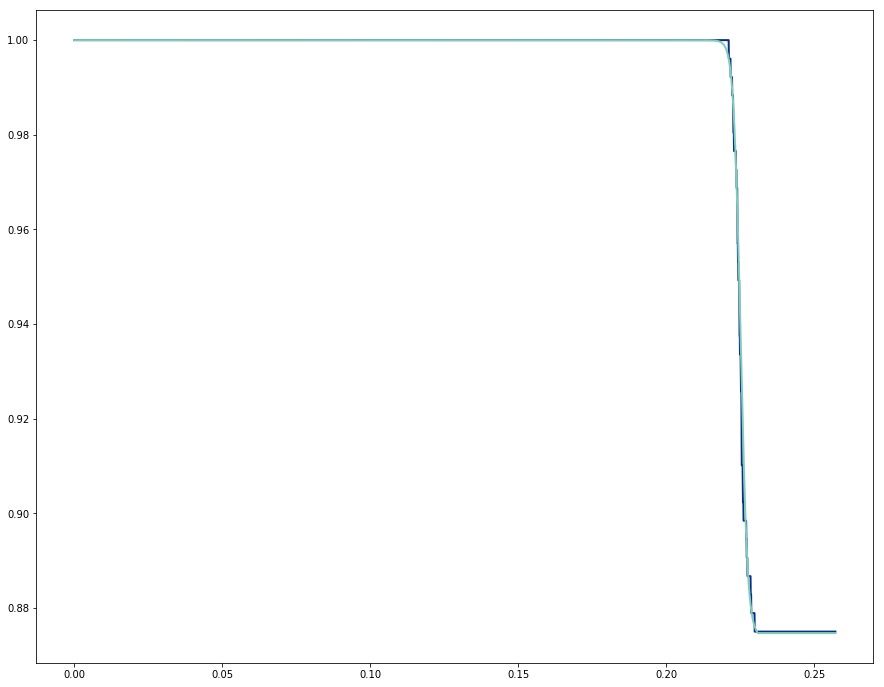

In [9]:
Wi_cs = np.linspace(6, 20, 50)
results = []

for Wi_c in Wi_cs:

    threshold = Wi_c/(8*0.0142)

    for scenario, data in dataset.items():
        population = np.zeros_like(data['t'])
        for molecule in data['g_max']:
            for i, g in enumerate(molecule):
                if g < threshold:
                    population[i] += 1
                else:
                    break
        data['population'] = population/len(data['g_max'])

    ###############################""

    def k_model(x):
        C, alpha = x
        k = C* Wi_c*np.abs(A_dot_gradU/Wi_c/L_max**2)**alpha #* (trA/L_max**2)**beta
        k[A_dot_gradU/trA<Wi_c] = 0
        return k

    def cost(x):
        pop_sim = np.ones_like(data['t'])
        dts = np.diff(data['t'])
        k = k_model(x)
        for i, dt in enumerate(dts):
            pop_sim[i+1] = pop_sim[i] - dt*pop_sim[i]*k[i]
        return np.sum((data['population']-pop_sim)**2)

    from scipy.optimize import minimize

    res = minimize(cost, x0=[1., 2])
    print(res.message)
    print(res.x)
    results.append(res.x)
    

plt.plot(data['t'], data['population'], c='#0c2c84', linewidth=2)
pop_sim = np.ones_like(data['t'])
dts = np.diff(data['t'])
k = k_model(res.x)
for i, dt in enumerate(dts):
    pop_sim[i+1] = pop_sim[i] - dt*pop_sim[i]*k[i]
plt.plot(data['t'], pop_sim, c='#7fcdbb', linewidth=2)
plt.show()

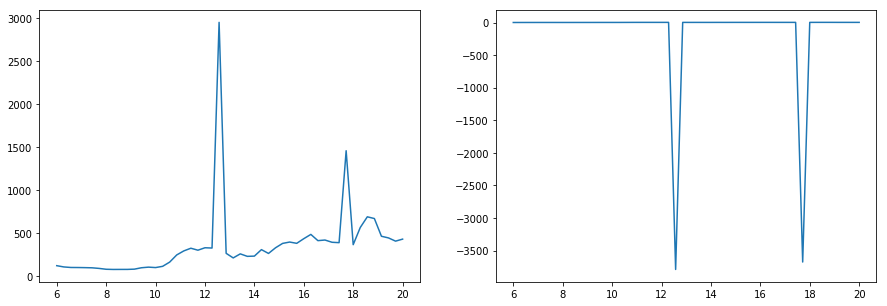

In [10]:
results = np.array(results)
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(ncols=2)
ax[0].plot(Wi_cs, results[:,0])
ax[1].plot(Wi_cs, results[:,1])

## Detail of $k$

Using total variation derivative

## Using smoothed population

(3200, 4000)

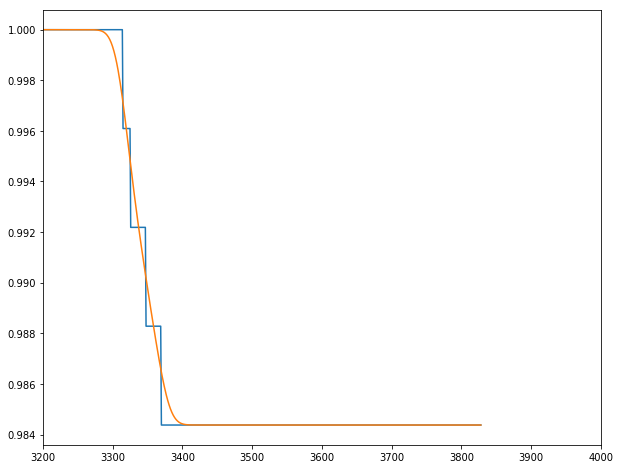

In [123]:
Wi_c =  50
threshold = Wi_c/(8*0.0142)

for scenario, data in dataset.items():
    population = np.zeros_like(data['t'])
    for molecule in data['g_max']:
        for i, g in enumerate(molecule):
            if g < threshold:
                population[i] += 1
            else:
                break
    data['population'] = population/len(data['g_max'])


pop_rough = data['population']

# Need decrete cosine formulation
mirror = np.hstack((pop_rough, np.flip(pop_rough[1:])))
p_hat = np.fft.rfft(mirror)
f = np.fft.rfftfreq(len(mirror))
filter_ = np.exp(-(60*f)**2)
pop_smooth_m = np.fft.irfft(filter_*p_hat, n=len(mirror))
pop_smooth = pop_smooth_m[:len(pop_rough)]

plt.plot(pop_rough)
plt.plot(pop_smooth)
plt.xlim(3200, 4000)

(3200, 4000)

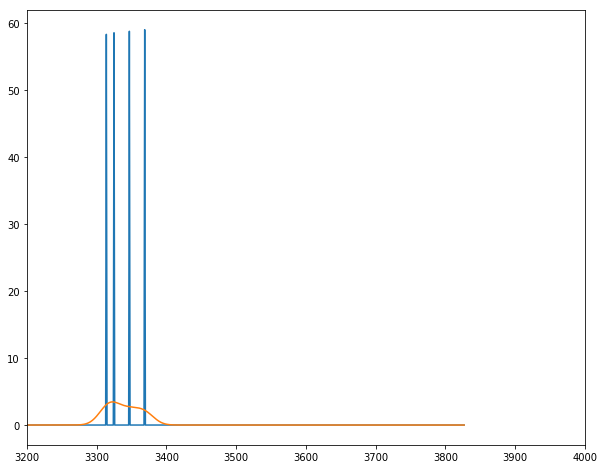

In [124]:
k_noisy = -np.diff(np.log(data['population']))/np.diff(data['t'])
k_smooth = -np.diff(np.log(pop_smooth))/np.diff(data['t'])

plt.plot(k_noisy)
plt.plot(k_smooth)
plt.xlim(3200, 4000)

(3000, 3500)

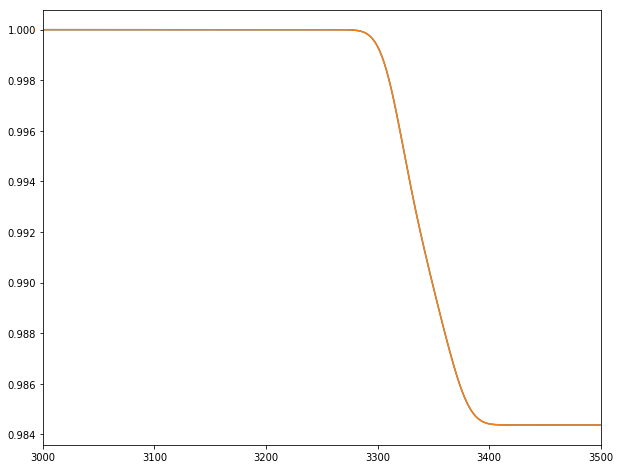

In [125]:
# Sanitiy check

pop_sim = np.ones_like(data['t'])
dts = np.diff(data['t'])
for i, dt in enumerate(dts):
    pop_sim[i+1] = pop_sim[i] - dt*pop_sim[i]*k_smooth[i]
    
plt.plot(pop_smooth)
plt.plot(pop_sim)
plt.xlim(3000, 3500)

## Inspection

Text(0.5, 0, 'k smooth')

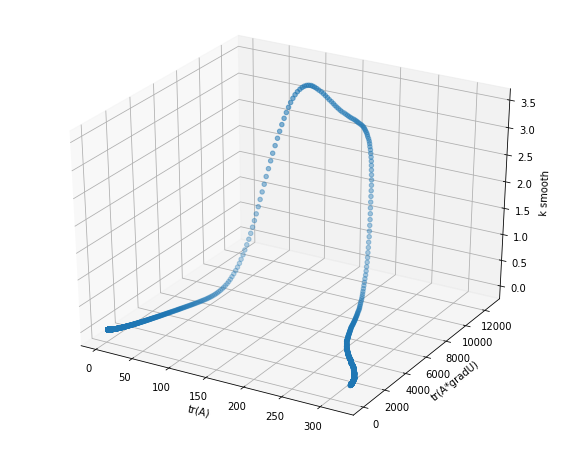

In [126]:
plt.rcParams['figure.figsize'] = [10, 8]
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(trA[1:], A_dot_gradU[1:], k_smooth)
ax.set_xlabel('tr(A)')
ax.set_ylabel('tr(A*gradU)')
ax.set_zlabel('k smooth')

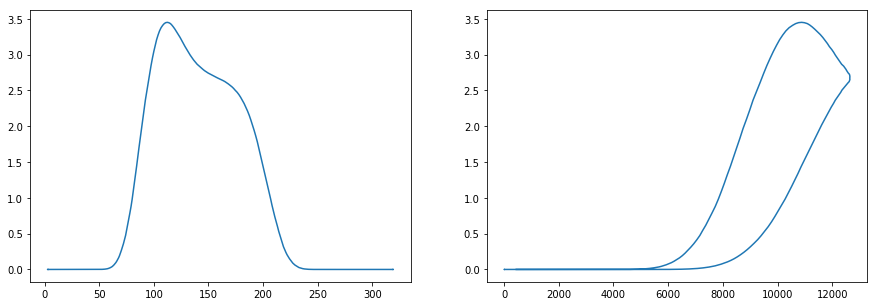

In [127]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots(ncols=2)
ax[0].plot(trA[1:], k_smooth)
ax[1].plot(A_dot_gradU[1:], k_smooth)

## Regression

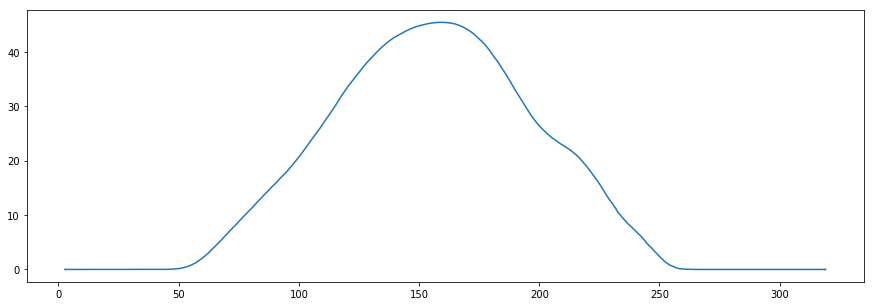

In [97]:
plt.plot(trA[1:], k_smooth)

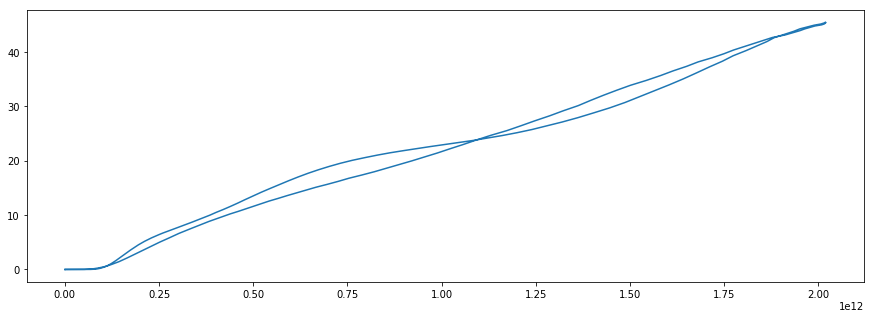

In [98]:
plt.plot(A_dot_gradU[1:]**3, k_smooth)

In [99]:
X = np.vstack((trA[1:]**(-1),
               trA[1:]**0.5,
              trA[1:],
              trA[1:]**1.5,
              trA[1:]**2,
              trA[1:]*A_dot_gradU[1:],
              A_dot_gradU[1:]**2)).T


from matsindy.optimizer import ridge

beta = ridge(X, k_smooth, 0.0001)
print(beta)

[ 4.51885634e-03  2.99431593e-02  4.52605824e-02 -3.35352220e-02
  1.72124068e-03  5.78595839e-06  2.93898636e-07]


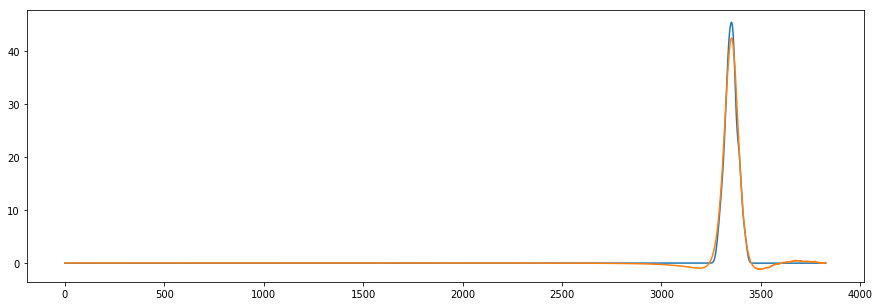

In [100]:
k_predict = np.sum(X*beta, axis=1)

plt.plot(k_smooth)
plt.plot(k_predict)

In [128]:
0.0142*1567**2*5.9e-3

205.72086842

In [129]:
0.0142*12658**2*3.8e-5

86.45739057440001

In [132]:
np.sqrt(1./(2*0.0142*10*3.8e-5))

304.40307248965405

In [133]:
1567/77

20.350649350649352

In [136]:
(2*200)**0.5

20.0